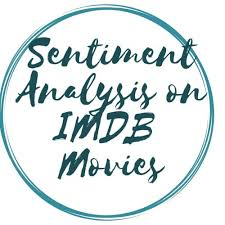

In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
Image(filename='./images/imdb.jpeg')

### Objective :  
- We will build a deep learning model to detect sentiment (i.e. detect if a sentence is positive or negative) using PyTorch and TorchText
-  This will be done on movie reviews, using the IMDb dataset.


### Introduction to  Long Short-Term Memory(LSTM):
- **LSTM is a type of recurrent neural network architecture that is commonly used in deep learning for processing sequential data.**
- **LSTMs are designed to remember information for longer periods of time. They achieve this by using a system of gates to selectively control the flow of information into and out of the network's memory cells.**
**GATES USED IN LSTM**
- The basic LSTM unit consists of three gates: an input gate, a forget gate, and an output gate. 
- **INPUT GATE** - The input gate controls the flow of new information into the memory cell.
- **FORGET GATE** - Controls whether or not to erase information from the memory cell.
- **OUTPUT GATE** - Controls the flow of information out of the memory cell.
- **CELL STATE** - there is a cell state that serves as the "memory" of the LSTM.

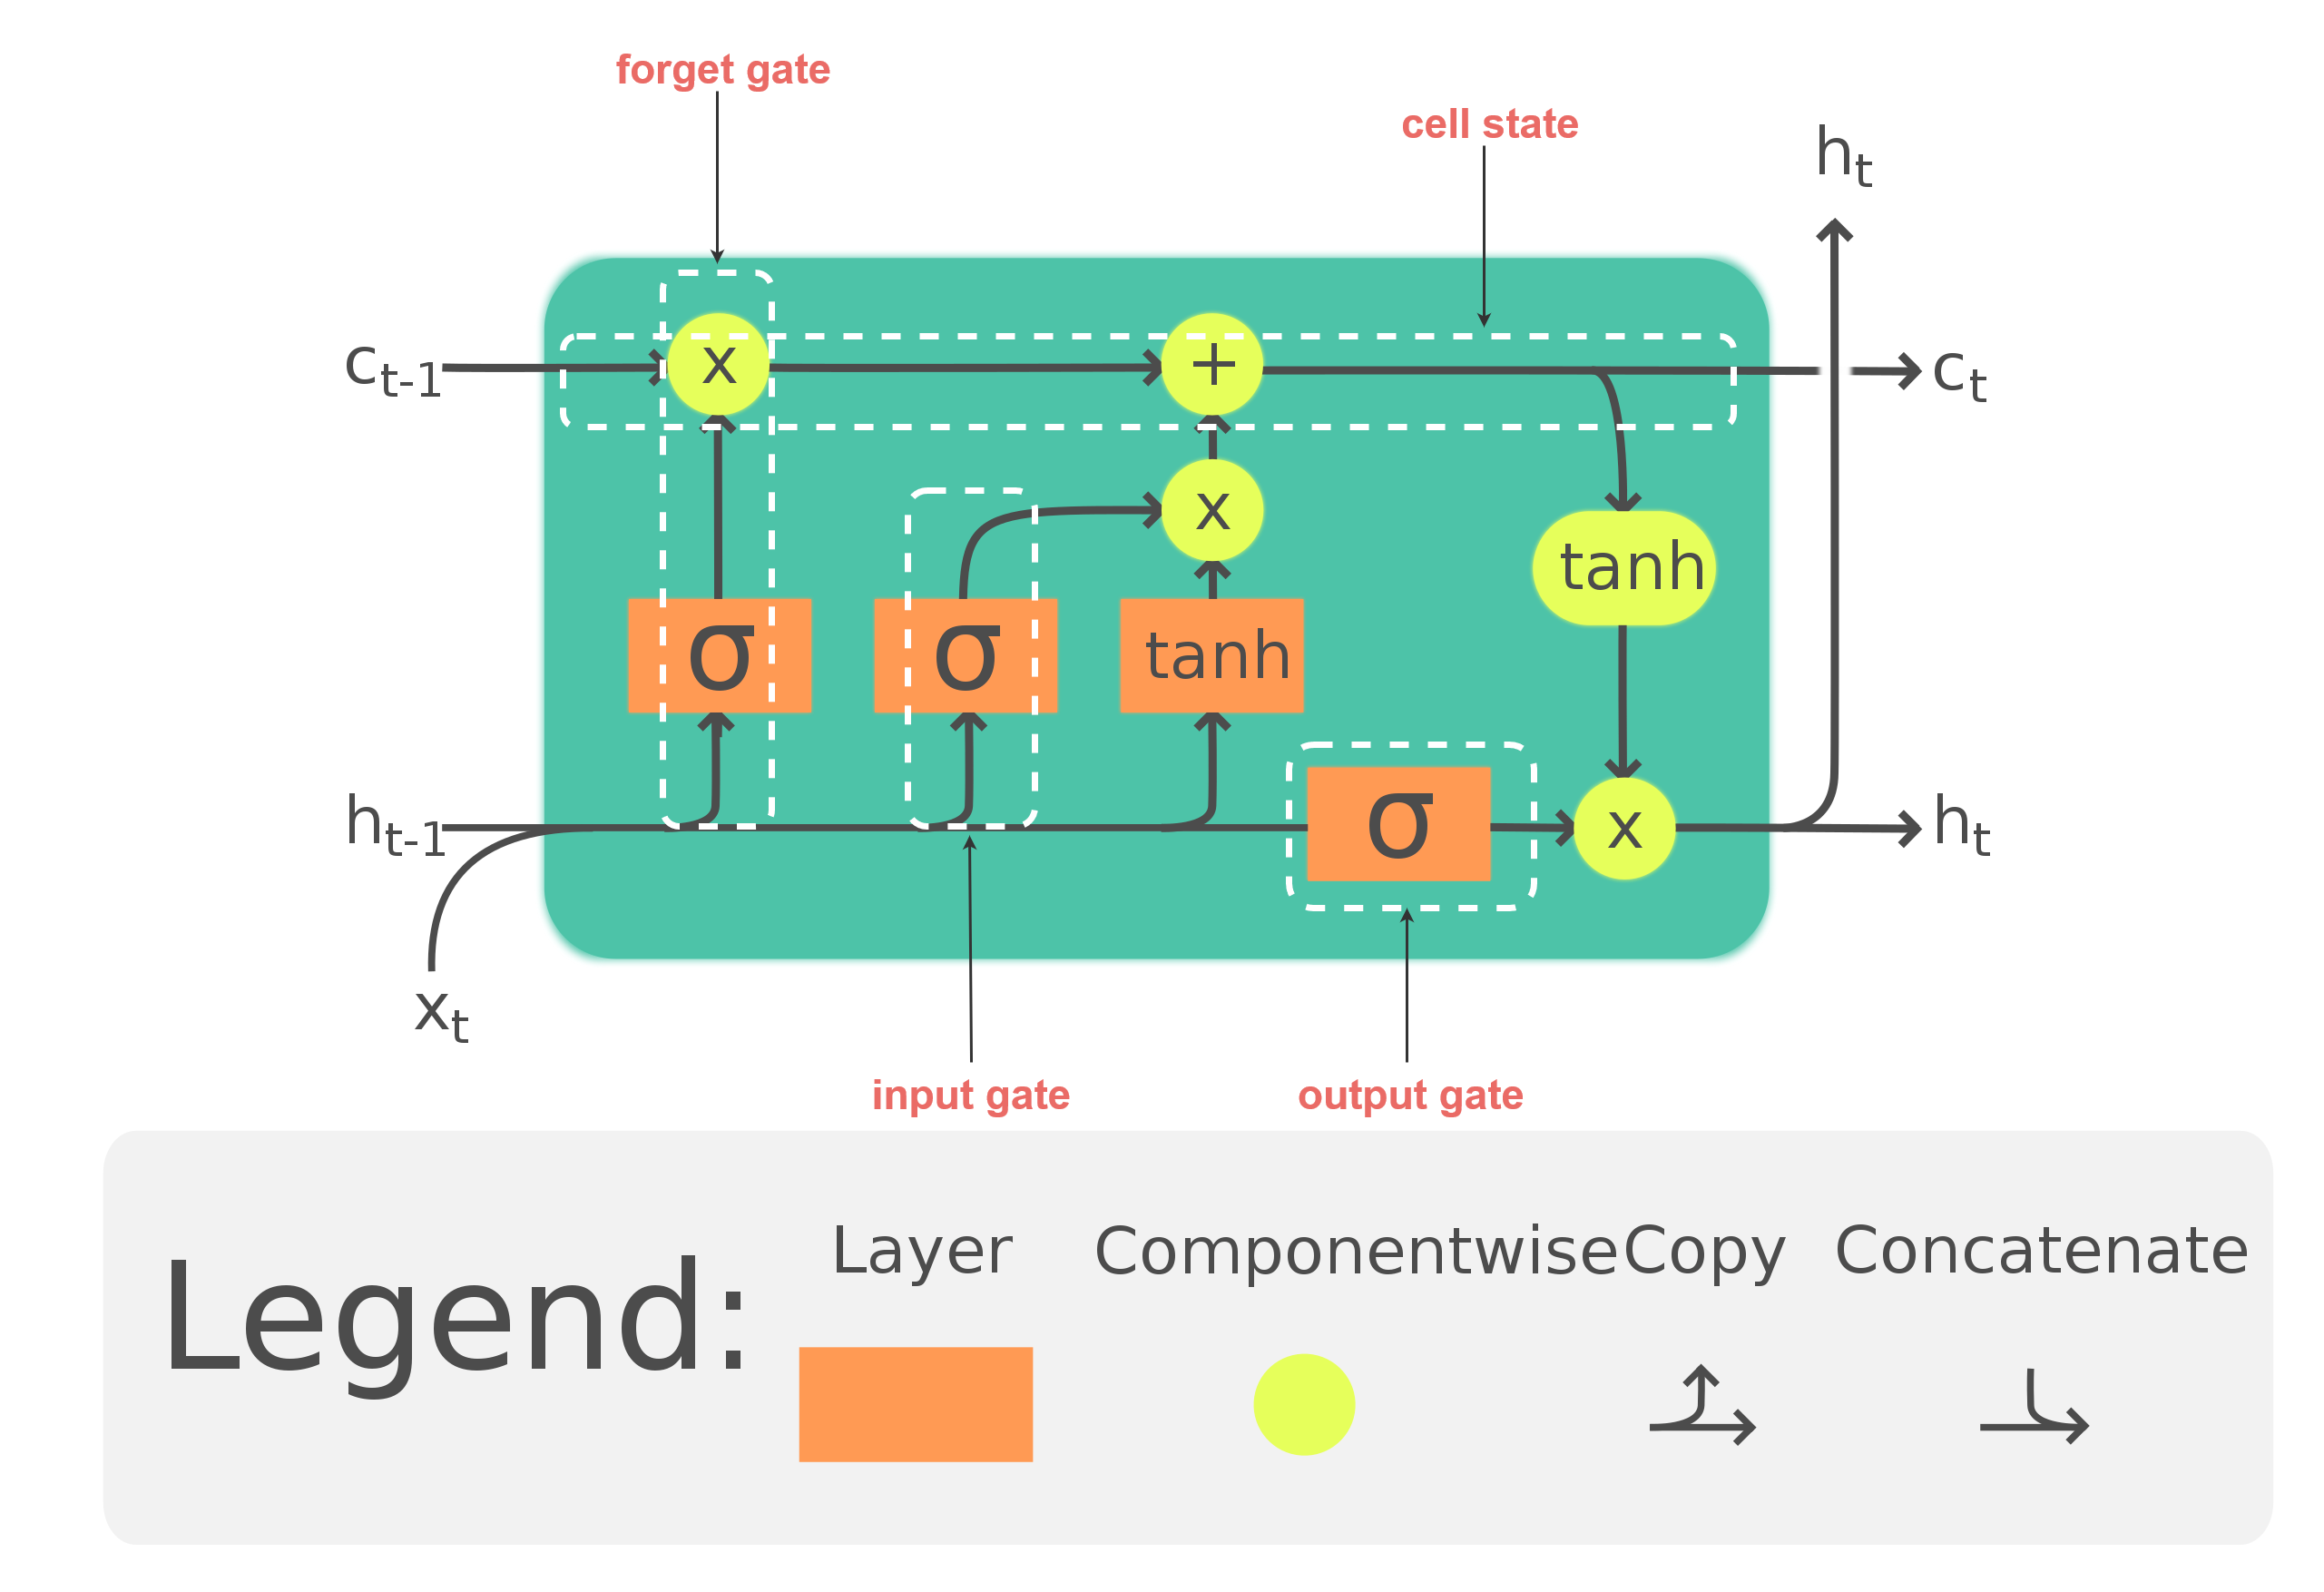

In [2]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
Image(filename='./images/lstm.png')

LSTM Network is organized in a manner similar to RNN, but there are two states that are being passed from layer to layer: `actual state` $c$, and `hidden vector` $h$. 
- At each unit, hidden vector $h_i$ is concatenated with input $x_i$, and they `control what happens to the state $c$ via **gates**. 
- Each gate is a neural network with `sigmoid` (${\sigma}$) activation (output in the range $[0,1]$), which can be thought of as bitwise mask when multiplied by the state vector. 

There are the following gates (from left to right on the picture above):
* **forget gate** takes hidden vector and determines, which components of the vector $c$ we need to forget, and which to pass through. The gate determines which words are not important and sigmod values close to zero need to be thrown out.  The formula is $f_t = \sigma(W_f  * [x_t + h_{t-1}] + b_f)$.
* **input gate** takes some information from the input and hidden vector, and inserts it into state. The formula for the input gate is a product of the new information $i_t = \sigma(W_i  * [x_t + h_{t-1}] + b_f)$ and the hidden  $\tilde{C_t} = \tanh(W_f  * [x_t + h_{t-1}] + b_f)$
* **output gate** transforms state via some linear layer with `tanh` activation, then selects some of its components using hidden vector $h_i$ to produce new state $c_{i+1}$.  The formula for the input gate is $o_t = \sigma(W_o  * [x_t + h_{t-1}] + b_f)$ and the hidden is ${h_t} = {o_t} * \tanh(C_t) $
* **cell state**  takes a product of the hidden state and the forget gate.  Then sums value with the product of the input gate and output gate. $C_t = f_t \circ C_{t-1} + i_t \circ \tilde{C_t}$ 

Components of the state $c$ can be thought of as some flags that can be switched on and off. For example, when we encounter a name *'Alice'* in the sequence, we may want to assume that it refers to female character, and raise the flag in the state that we have female noun in the sentence. When we further encounter phrases *and Tom*, we will raise the flag that we have plural noun. Thus by manipulating state we can supposedly keep track of grammatical properties of sentence parts.

> **Note**: A great resource for understanding internals of LSTM is this great article "Understanding LSTM Networks" by Christopher Olah.

While internal structure of LSTM cell may look complex, PyTorch hides this implementation inside the `LSTMCell` class, and provides a `LSTM` object to represent the whole LSTM layer. Thus, implementation of LSTM classifier will be pretty similar to the simple RNN which we have seen above:


####  Importing libraries

In [ ]:
import torch
from torchtext.legacy import data

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm')
LABEL = data.LabelField(dtype = torch.float)

- In torchtext `Field` defines how our data should be processed.
- Our `TEXT` field has tokenize='spacy' as an argument, that defines tokenization should be done using spacy tokenizer.
- We also need to specify a `tokenizer_language` which tells torchtext which spaCy model to use.
- We will use `en_core_web_sm model` which has to be downloaded with python -m spacy download en_core_web_sm.
- LABEL is defined by a `LabelField`, a special subset of the Field class specifically used for handling labels.

In [ ]:
from torchtext.legacy import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

In [ ]:
import random
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

#### Build a vocabulary
- We will make use of pre-trained word embedding.
- Now  instead of having our word embeddings initialized randomly, they are initialized with these pre-trained vectors.
- We get these vectors simply by specifying which vectors we want and passing it as an argument to `build_vocab`.
- `TorchText` handles downloading the vectors and associating them with the correct words in our vocabulary.
- We'll be using the `"glove.6B.100d" vectors"`, 6B indicates these vectors were trained on 6 billion tokens and 100d indicates these vectors are 100-dimensional.

In [ ]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

#### View the most common words in the vocabulary and their frequencies

In [ ]:
print(TEXT.vocab.freqs.most_common(10))

In [ ]:
print(TEXT.vocab.itos[:10])

In [ ]:
print(LABEL.vocab.stoi)

#### The final step of preparing the data is creating the iterators
- We'll use a BucketIterator which is a special type of iterator that will return a batch of examples where each example is of a similar length, minimizing the amount of padding per example.
- Another thing for packed padded sequences all of the tensors within a batch need to be sorted by their lengths. This is handled in the iterator by setting sort_within_batch = True.

In [ ]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

#### Build the Model

Within the `__init__` we define the layers of the module. Our three layers are an embedding layer, our RNN, and a linear layer. All layers have their parameters initialized to random values.
- 1.`Embedding layer` -  The embedding layer is used to transform our sparse one-hot vector (sparse as most of the elements are 0) into a dense embedding vector (dense as the dimensionality is a lot smaller and all the elements are real numbers). This embedding layer is simply a single fully connected layer. As well as reducing the dimensionality of the input to the RNN.
- 2.`RNN Layer` - The RNN layer is our LSTM which takes in our dense vector,the previous hidden state H(t-1) and previous cell state C(t-1) which it used to calculate the next hidden state H(t) and cell state C(t).
- 3.`Linear Layer` -  The linear layer takes the final hidden state and feeds it through a fully connected layer then transforming it to the correct output dimension.

- Implementing bidirectionality and adding additional layers are done by passing values for the num_layers and bidirectional arguments for the RNN/LSTM.
- Dropout is implemented by initializing an nn.Dropout layer (the argument is the probability of dropping out each neuron) and using it within the forward method after each layer we want to apply dropout to.

**Note : 
- **LSTM returns the output and a tuple of the final hidden state and the final cell state, whereas the standard RNN only returned the output and final hidden state.**
- **Never use dropout on the input or output layers (text or fc in this case), you only ever want to use dropout on intermediate layers.**

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden)

- The forward method is called when we feed examples into our model.
- As we are passing the lengths of our sentences to be able to use packed padded sequences, we have to add a second argument, `text_lengths` to forward.
- Before we pass our embeddings to the RNN, we need to pack them, which we do with `nn.utils.rnn.packed_padded_sequence`. This will cause our RNN to only process the non-padded elements of our sequence. 
- The RNN will then return packed_output (a packed sequence) as well as the hidden and cell states (both of which are tensors).
- `text` is a tensor of size **[sentence length, batch size]**. That is a batch of sentences, each having each word converted into a one-hot vector.
- The final hidden state, hidden, has a shape of **[num layers * num directions, batch size, hid dim]**.
- `embedded` is then fed into the RNN. 
- As we want the final (top) layer forward and backward hidden states, we get the top two hidden layers from the first dimension, **hidden[-2,:,:]** and **hidden[-1,:,:]**, and concatenate them together before passing them to the linear layer (after applying dropout).**. 

#### Create an instance of our RNN class
`Note` 
- To ensure the pre-trained vectors can be loaded into the model, the EMBEDDING_DIM must be equal to that of the pre-trained GloVe vectors loaded earlier.

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

#### Replace the initial weights of the embedding layer with the pre-trained embeddings.

In [ ]:
model.embedding.weight.data.copy_(pretrained_embeddings)

#### Train the Model

**1. Create an optimizer**
- Optimizer is algorithm we use to update the parameters of the model.
- For this task we will use ***Adam ***.
- why we are chosing Adam not SGD is because SGD updates all parameters with the same learning rate and choosing this learning rate can be tricky. 
- Adam adapts the learning rate for each parameter giving parameters that are updated more frequently lower learning rates and parameters that are updated infrequently higher learning rates

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

**2. Define our loss function (In PyTorch this is commonly called a criterion)**
- We will use binary cross entropy with logits.
- Our model currently outputs an unbound real number. As our labels are either 0 or 1, we want to restrict the predictions to a number between 0 and 1. We do this using the sigmoid or logit functions.
- The BCEWithLogitsLoss criterion carries out both the sigmoid and the binary cross entropy steps.

In [ ]:
criterion = nn.BCEWithLogitsLoss()

#### Move the model and the criterion on the GPU (if we have one)

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:

N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

####  Test loss and accuracy

In [ ]:
model.load_state_dict(torch.load('rnn-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')